## Improving CNN Training with Data Augmentation and Dropout

#### We will be implementing data augmentation and adding a dropout layer to help solve the issue with overfitting in our model.

# Detecting and Classifying Skin Cancers With CNN Model

### Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Libraries

In [ ]:
import os
import cv2
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.metrics import f1_score

import tensorflow
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from  tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.optimizers import Adam, SGD

### Define Paths and Training Data

In [ ]:
# Create paths for our cropped images
os.chdir('/content/drive/MyDrive/Skin_Lesion_Project')
dirpath = os.getcwd()
cropped_PATH = os.path.join(dirpath, 'Data Cleaning and Pre-Processing/Cropped_Images')
cropped_ak = os.path.join(cropped_PATH, 'actinic keratosis')
cropped_bcc = os.path.join(cropped_PATH, 'basal cell carcinoma')
cropped_derm = os.path.join(cropped_PATH, 'dermatofibroma')
cropped_mel = os.path.join(cropped_PATH, 'melanoma')
cropped_nev = os.path.join(cropped_PATH, 'melanocytic nevi')
cropped_bkl = os.path.join(cropped_PATH, 'benign keratosis')
cropped_vl = os.path.join(cropped_PATH, 'vascular lesion')

cropped_files_ak = os.listdir(cropped_ak)
cropped_files_bcc = os.listdir(cropped_bcc)
cropped_files_derm = os.listdir(cropped_derm)
cropped_files_mel = os.listdir(cropped_mel)
cropped_files_nev = os.listdir(cropped_nev)
cropped_files_pbk = os.listdir(cropped_bkl)
cropped_files_vl = os.listdir(cropped_vl)

cropped_paths_ak = [os.path.join(cropped_ak, file) for file in cropped_files_ak]
cropped_paths_bcc = [os.path.join(cropped_bcc, file) for file in cropped_files_bcc]
cropped_paths_derm = [os.path.join(cropped_derm, file) for file in cropped_files_derm]
cropped_paths_mel = [os.path.join(cropped_mel, file) for file in cropped_files_mel]
cropped_paths_nev = [os.path.join(cropped_nev, file) for file in cropped_files_nev]
cropped_paths_bkl = [os.path.join(cropped_bkl, file) for file in cropped_files_pbk]
cropped_paths_val = [os.path.join(cropped_vl, file) for file in cropped_files_vl]

class_names = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'melanocytic nevi', 'benign keratosis', 'vascular lesion']

# Create a dataframes of our cropped images and their label
df_ak = pd.DataFrame({'image': cropped_paths_ak, 'label': class_names[0]})
df_bcc = pd.DataFrame({'image': cropped_paths_bcc, 'label': class_names[1]})
df_derm = pd.DataFrame({'image': cropped_paths_derm, 'label': class_names[2]})
df_mel = pd.DataFrame({'image': cropped_paths_mel, 'label': class_names[3]})
df_nev = pd.DataFrame({'image': cropped_paths_nev, 'label': class_names[4]})
df_bkl = pd.DataFrame({'image': cropped_paths_bkl, 'label': class_names[5]})
df_vl = pd.DataFrame({'image': cropped_paths_val, 'label': class_names[6]})

# Combine dataframe of image paths and their label to train
train_data = pd.concat([df_ak, df_bcc, df_derm, df_mel, df_nev, df_bkl, df_vl])

print("Training data has been created!")

Training data has been created!


In [ ]:
# Create data gen with object with parameters for data augmentation
datagen = ImageDataGenerator(
    rotation_range = 10,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True
)

In [ ]:
# Set image size and batch size for training
image_size = (256, 256)
batch_size = 32

# Create train_batches using flow_from_directory
train_batches = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    classes= class_names,
    shuffle = True
)

# Create test_batches using flow_from_directory
test_batches = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    classes = class_names,
    shuffle = False
)

# Create validation set using flow_from_directory
val_batches = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    classes = class_names,
    shuffle = False
)

Found 1791 validated image filenames belonging to 9 classes.
Found 448 validated image filenames belonging to 9 classes.


In [ ]:
# Get train data and labels by iterating with our train data generator
train_iter2 = iter(train_generator2)
train_data, train_labels = next(train_iter2)

In [ ]:
# Setting seed and reshaping data for training
sm = SMOTE(random_state=41)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 256 * 256 * 3), train_labels)
train_data = train_data.reshape(-1, 256,256, 3)
print(train_data.shape, train_labels.shape)

(3177, 256, 256, 3) (3177, 9)


### Define Same CNN Architecture
This time add dropout layer to prevent overfitting

In [ ]:
from tensorflow.keras import backend as K

# Clearing previous models from memory
K.clear_session()

# Intialize a sequential model
model_cnn_aug=keras.models.Sequential()

# Add first convolution layer of 32 filters of size 3x3 with stride 2
model_cnn_aug.add(keras.layers.Conv2D(32,kernel_size=(3,3),strides=2,padding='same',activation='relu',input_shape=(256,256, 3)))
# Add a max pooling layer of size 2x2 with stride 2
model_cnn_aug.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'))

# Add second convolution layer of 64 filters of size 3x3 with stride 2
model_cnn_aug.add(keras.layers.Conv2D(64,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
# Add a max pooling layer of size 2x2 with stride 2
model_cnn_aug.add(keras.layers.MaxPool2D((2,2),2,padding='same'))

# Add third convolution layer of 128 filters of size 3x3 with stride 2
model_cnn_aug.add(keras.layers.Conv2D(128,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
# Add a thrid max pooling layer of size 2x2 with stride 2
model_cnn_aug.add(keras.layers.MaxPool2D((2,2),2,padding='same'))

# Flatten output from previous layers
model_cnn_aug.add(keras.layers.Flatten())

# Add a fully connected dense layer of 1024 neurons
model_cnn_aug.add(keras.layers.Dense(1024,activation='relu'))

# Add dropout layer (30% of neurons will be randomly turned off to prevent overfitting)
model_cnn_aug.add(keras.layers.Dropout(0.3))

# Add output layer of 9 neuros (one for each class)
model_cnn_aug.add(keras.layers.Dense(9,activation='softmax'))

# Display model architecture
model_cnn_aug.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           9,225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,200,649 (8.39 MB)

 Trainable params: 2,200,649 (8.39 MB)

 Non-trainable params: 0 (0.00 B)

### Define Handy Call Back Functions and Train Model

In [ ]:
# Folder name to save our model
model_folder = 'model_cnn_aug'
# Path to save our CNN model to
checkpoint_file = os.path.join(dirpath, model_folder, 'checkpoint.model.keras')
# Saves the model only if its performance improves
checkpoint_cb = ModelCheckpoint(checkpoint_file, save_best_only=True)
# Stop early if model's performance doesn't imporve for 5 epochs
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
# Model compilation
model_cnn_aug.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy',keras.metrics.SpecificityAtSensitivity(0.5),keras.metrics.AUC()])
# Train our model
hist_aug=model_cnn_aug.fit(train_data,
               train_labels,
               validation_split=.1,
               epochs=50,
               callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 73s 778ms/step - accuracy: 0.1609 - auc: 0.6254 - loss: 2.0924 - specificity_at_sensitivity: 0.6267 - val_accuracy: 0.0000e+00 - val_auc: 0.4199 - val_loss: 2.5433 - val_specificity_at_sensitivity: 0.3687
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 66s 607ms/step - accuracy: 0.2886 - auc: 0.7769 - loss: 1.7829 - specificity_at_sensitivity: 0.8232 - val_accuracy: 0.1006 - val_auc: 0.6309 - val_loss: 2.0385 - val_specificity_at_sensitivity: 0.5947
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 84s 636ms/step - accuracy: 0.3804 - auc: 0.8412 - loss: 1.5603 - specificity_at_sensitivity: 0.8897 - val_accuracy: 0.5031 - val_auc: 0.8729 - val_loss: 1.2958 - val_specificity_at_sensitivity: 0.9796
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 79s 599ms/step - accuracy: 0.4352 - auc: 0.8629 - loss: 1.4561 - specificity_at_sensitivity: 0.9129 - val_accuracy: 0.3836 - val_auc: 0.8089 - val_loss: 1.6624 - val_specificity_at_sensitivity: 0.8656
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 88

### Outputting Results of Augmented Model Training



In [ ]:
# Create a dataframe of our training session and store it in google drive
hist_cnn_aug=pd.DataFrame(hist_aug.history)
hist_cnn_aug.to_csv('/content/drive/MyDrive/Skin_Lesion_Project/output_aug.csv', index=False)
hist_cnn_aug

,accuracy,auc,loss,specificity_at_sensitivity,val_accuracy,val_auc,val_loss,val_specificity_at_sensitivity
0,0.218958,0.712660,1.941181,0.739507,0.000000,0.419869,2.543316,0.368711
1,0.314795,0.791798,1.732657,0.841859,0.100629,0.630854,2.038532,0.594733
2,0.384050,0.842438,1.546096,0.893800,0.503145,0.872857,1.295821,0.979560
3,0.433368,0.861276,1.461481,0.909496,0.383648,0.808859,1.662418,0.865566
4,0.441413,0.866796,1.434721,0.917760,0.647799,0.929224,0.998277,0.999607
5,0.485484,0.886180,1.335418,0.937260,0.635220,0.932577,0.993542,0.999607
6,0.523959,0.898072,1.268126,0.949589,0.638365,0.946591,0.908970,0.999214
7,0.544596,0.910813,1.188694,0.958465,0.500000,0.906319,1.229591,0.953223
8,0.585170,0.922691,1.108487,0.969089,0.732704,0.968845,0.683030,0.999214
9,0.598461,0.927789,1.072079,0.970269,0.701258,0.960287,0.786025,1.000000


### Plot Training and Validation Accuracy of Augmented Model

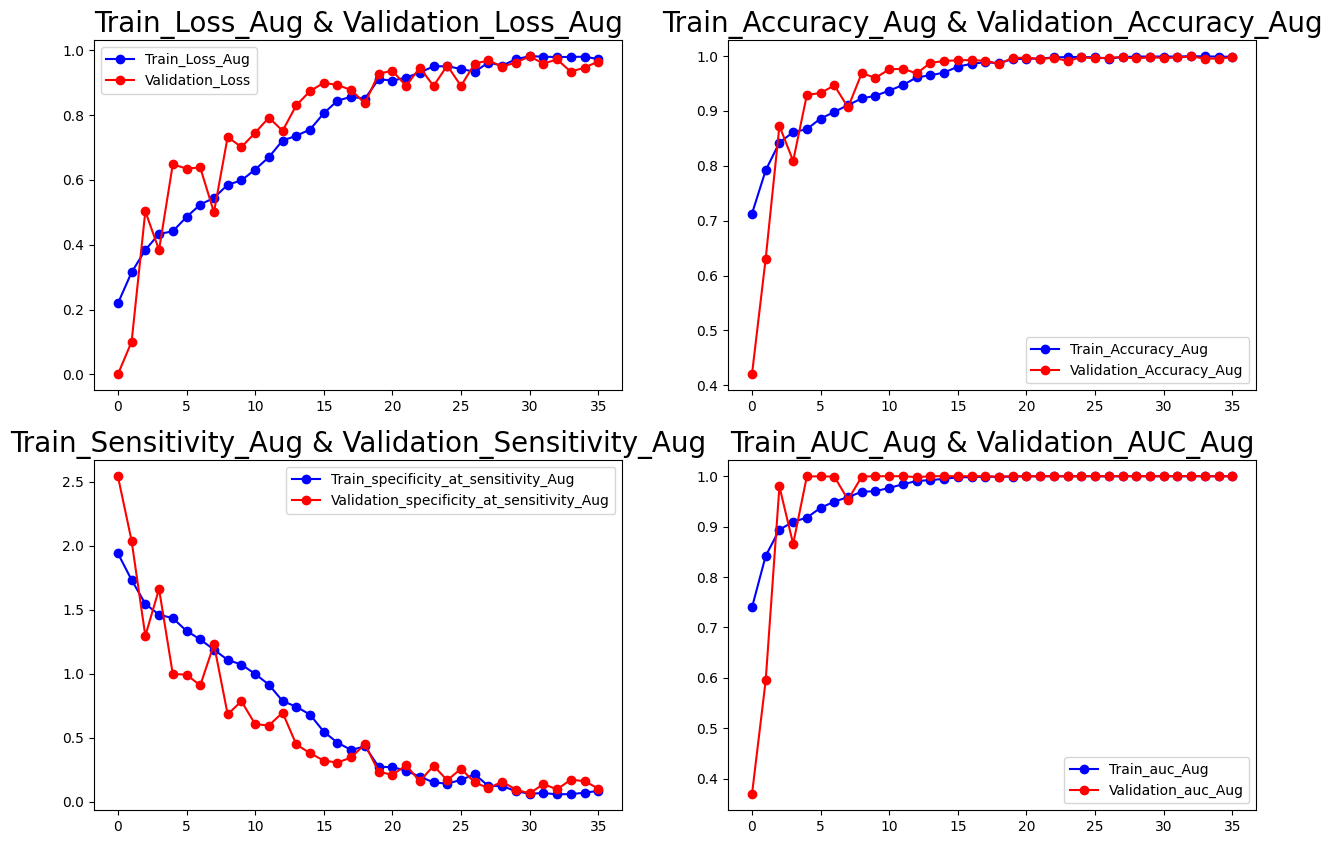

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(hist_cnn_aug.iloc[:,0],'b-o',label='Train_Loss_Aug')
plt.plot(hist_cnn_aug.iloc[:,4],'r-o',label='Validation_Loss')
plt.title('Train_Loss_Aug & Validation_Loss_Aug',fontsize=20)
plt.legend()
plt.subplot(2,2,2)
plt.plot(hist_cnn_aug.iloc[:,1],'b-o',label='Train_Accuracy_Aug')
plt.plot(hist_cnn_aug.iloc[:,5],'r-o',label='Validation_Accuracy_Aug')
plt.title('Train_Accuracy_Aug & Validation_Accuracy_Aug',fontsize=20)
plt.legend()
plt.subplot(2,2,3)
plt.plot(hist_cnn_aug.iloc[:,2],'b-o',label='Train_specificity_at_sensitivity_Aug')
plt.plot(hist_cnn_aug.iloc[:,6],'r-o',label='Validation_specificity_at_sensitivity_Aug')
plt.title('Train_Sensitivity_Aug & Validation_Sensitivity_Aug',fontsize=20)
plt.legend()
plt.subplot(2,2,4)
plt.plot(hist_cnn_aug.iloc[:,3],'b-o',label='Train_auc_Aug')
plt.plot(hist_cnn_aug.iloc[:,7],'r-o',label='Validation_auc_Aug')
plt.title('Train_AUC_Aug & Validation_AUC_Aug',fontsize=20)
plt.legend()
plt.show()

### Augmented CNN Model Evaluation

In [ ]:
score_aug, acc_aug,sensitivity_aug,auc_aug = model_cnn_aug.evaluate(test_generator2)
print('Test Aug Loss =', score_aug)
print('Test Aug Accuracy =', acc_aug)
print('Test Aug Sensitivity =', sensitivity_aug)
print('Test Aug AUC =', auc_aug)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.4955 - auc: 0.8069 - loss: 3.6680 - specificity_at_sensitivity: 0.9342
Test Aug Loss = 3.6680030822753906
Test Aug Accuracy = 0.4955357015132904
Test Aug Sensitivity = 0.9341517686843872
Test Aug AUC = 0.8069125413894653


### F1 Score of Augmented Model

In [ ]:
# Make predictions on the validation set
y_val_pred = model_cnn_aug.predict(train_data)

# Convert predictions from probabilities to class labels
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true_classes = np.argmax(train_labels, axis=1)  # Convert true labels if in categorical format

# Calculate the F1 score
f1 = f1_score(y_val_true_classes, y_val_pred_classes, average='weighted')

print(f"F1 Score: {f1:.4f}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step
F1 Score: 0.9915


### Use our Augmented Model to Predict Test Data

In [ ]:
y_test = test_generator2.classes
predictions = model_cnn_aug.predict(test_generator2)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


,Actual,Prediction
0,4,1
1,3,4
2,3,3
3,3,4
4,8,3
...,...,...
443,8,7
444,3,3
445,5,5
446,7,5


### Confusion Matrix from Augmented Model

array([[ 2,  6,  0,  0,  6,  4,  0,  4,  1],
       [ 2, 44,  2,  2,  5,  3,  0, 12,  5],
       [ 3,  2,  1,  2,  2,  1,  1,  6,  1],
       [ 0,  5,  1, 55, 15,  3,  9,  0,  0],
       [ 2,  8,  0, 17, 29,  7,  1,  6,  1],
       [ 3, 10,  4,  5, 15, 45,  2,  7,  2],
       [ 0,  0,  0, 12,  2,  1,  0,  0,  0],
       [ 3,  7,  1,  0,  6, 10,  0,  8,  1],
       [ 0,  1,  0,  1,  0,  1,  0,  2, 23]])

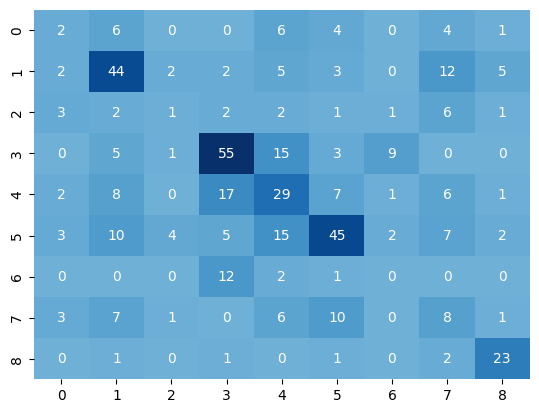

In [ ]:
CM = confusion_matrix(y_test,y_pred)
sns.heatmap(CM,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

## Using Augmented Model for Prediction

In [ ]:
# Function to preprocess the image
def preprocess_image(image_path, target_size):
    img = cv2.imread(image_path, cv2.COLOR_BGR2RGB)  # Load image in RGB
    img = cv2.resize(img, target_size)  # Resize to target size
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Preprocess the image
target_size = (256, 256)  # Replace with your model's expected input size
image_path = '/content/Cropped_Images/vascular lesion/ISIC_0025197.jpg'  # Replace with the path to your image
img = preprocess_image(image_path, target_size)

# Class Labels
class_labels = {0:'actinic keratosis', 1: 'basal cell carcinoma', 2: 'dermatofibroma', 3:'melanoma', 4:'nevus',
                5:'pigmented benign keratosis', 6:'seborrheic keratosis', 7:'squamous cell carcinoma', 8:'vascular lesion'}
# Make a prediction
prediction = model_cnn_aug.predict(img)

# Interpret the result
predicted_class = np.argmax(prediction, axis=1)[0]
predicted_label = class_labels[predicted_class]
print(f"Predicted class: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
Predicted class: vascular lesion


## Zip Model Folders and Transfer Files to Google Drive

In [ ]:
# Create a zip file of our CNN model
!zip -r model_cnn.zip model_cnn
# Create a zip file of our Augmented CNN model
!zip -r model_cnn_aug.zip model_cnn_aug

  adding: model_cnn/ (stored 0%)
  adding: model_cnn/checkpoint.model.keras (deflated 12%)
  adding: model_cnn_aug/ (stored 0%)
  adding: model_cnn_aug/checkpoint.model.keras (deflated 17%)


In [ ]:
# Transfer all files to our google drive folder
!sudo cp -v -r "/content/Cropped_Images/" "/content/drive/MyDrive/Skin_Lesion_Project"
!sudo cp -v -r "/content/Skin cancer ISIC The International Skin Imaging Collaboration/" "/content/drive/MyDrive/Skin_Lesion_Project"
!sudo cp -v -r "/content/model_cnn/" "/content/drive/MyDrive/Skin_Lesion_Project"
!sudo cp -v -r "/content/model_cnn.zip" "/content/drive/MyDrive/Skin_Lesion_Project"
!sudo cp -v -r "/content/skin-cancer9-classesisic.zip" "/content/drive/MyDrive/Skin_Lesion_Project"
!sudo cp -v -r "/content/model_cnn_aug/" "/content/drive/MyDrive/Skin_Lesion_Project"
!sudo cp -v -r "/content/model_cnn_aug.zip" "/content/drive/MyDrive/Skin_Lesion_Project"